# Generating new images with GAN

Directories:

* supervised: Images with mask labels
* unsupervised: Just images

In [4]:
# Import necessary modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
np.random.seed(1234)
%matplotlib inline

In [5]:
# Global constants.
STAGE1_TRAIN = "supervised/stage1_train"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"


## Read functions

In [42]:
def image_ids_in(root_dir, ignore=["stage1_train"]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [43]:
def read_image(image_id, space="rgb"):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [44]:
# Get image width, height and count masks available.
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 #index + 1
    return image, labels, num_masks

In [45]:
# Load stage 1 image identifiers.
train_image_ids = image_ids_in(STAGE1_TRAIN)

Skipping ID: stage1_train


## K means

In [46]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [47]:
def get_images_details(image_ids):
    details = []
    for image_id in image_ids:
        image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        details.append(info)
    return details

In [48]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [49]:
details = get_images_details(train_image_ids)

Run KMeans to split images by 3 types (based on dominant HSV colors distributions)

In [50]:
trainPD = pd.DataFrame(details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

Save K-means clasification in a csv fils called `clusters.csv`

In [59]:
trainPD[['image_id','hsv_cluster']].sort_values('hsv_cluster').to_csv('clusters.csv')

Visualize the clusters

In [9]:
P = trainPD.groupby(HSV_CLUSTER)[IMAGE_ID].count().reset_index()
P['Percentage'] = 100*P[IMAGE_ID]/P[IMAGE_ID].sum()
P

NameError: name 'trainPD' is not defined

In [60]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(image)

### Cluster A

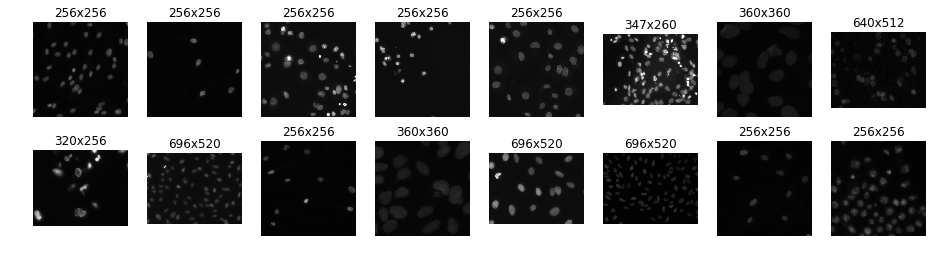

In [63]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 2, 8)

### Cluster B

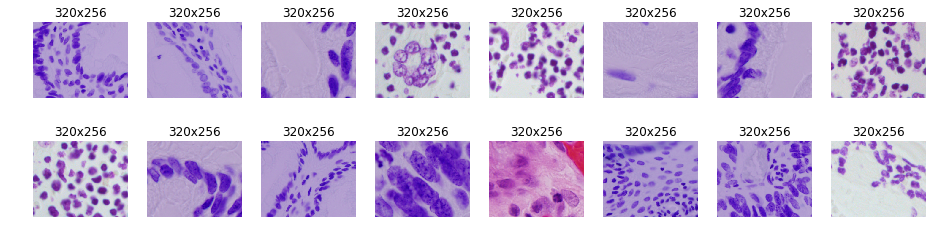

In [64]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 2, 8)

### Cluster C

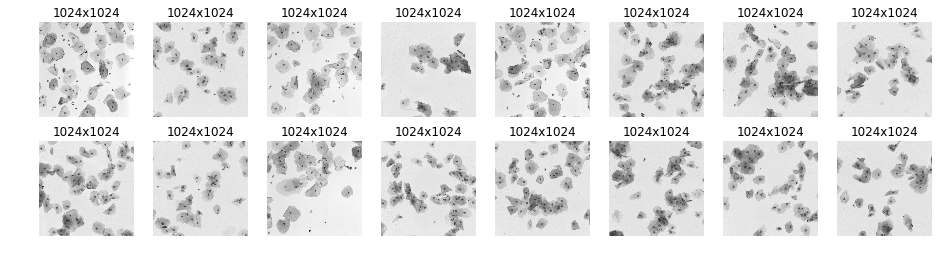

In [65]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 2, 8)

# CycleGAN
Now we are going to feed different clusters to a style transfer GAN.

We are going to use [this pytorch GAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

In [7]:
cluster_ids = pd.read_csv('clusters.csv')

In [43]:
clusterA_ids = cluster_ids[cluster_ids.hsv_cluster == 0]['image_id'].values.tolist()
clusterB_ids = cluster_ids[cluster_ids.hsv_cluster == 1]['image_id'].values.tolist()
clusterC_ids = cluster_ids[cluster_ids.hsv_cluster == 2]['image_id'].values.tolist()

GAN_DATA_DIR = "/home/javi/Escritorio/pytorch-CycleGAN-and-pix2pix/datasets/nuclei2nuclei"
clusterA_dir = GAN_DATA_DIR + "/clusterA"
clusterB_dir = GAN_DATA_DIR + "/clusterB"
clusterC_dir = GAN_DATA_DIR + "/clusterC"

if not os.path.exists(clusterA_dir):
    os.makedirs(clusterA_dir)
if not os.path.exists(clusterB_dir):
    os.makedirs(clusterB_dir)
if not os.path.exists(clusterC_dir):
    os.makedirs(clusterC_dir)


for id in clusterA_ids:
    src = "/home/javi/Escritorio/data/" + STAGE1_TRAIN_IMAGE_PATTERN.format(id, id)
    dst = clusterA_dir + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in clusterB_ids:
    src = "/home/javi/Escritorio/data/" + STAGE1_TRAIN_IMAGE_PATTERN.format(id, id)
    dst = clusterB_dir + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in clusterC_ids:
    src = "/home/javi/Escritorio/data/" + STAGE1_TRAIN_IMAGE_PATTERN.format(id, id)
    dst = clusterC_dir + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)


### Then you have in your CycleGAN data folder a new folder called nuclei2nuclei. Here there are all the clusters, rename two of them (or use symlinks) to "trainA" and "trainB". And execute the cycleGAN training